In [37]:
import datajoint as dj
import pandas as pd
from datetime import date
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from datetime import date,datetime,timedelta
#from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import os
import h5py
# Establish connection 
dj.config['database.host'] = '34.82.94.188'
dj.config['database.user'] = 'yonib'
dj.config['database.password'] = 'yonib'
dj.conn()

# configure a schema for testing stuff
schema  = dj.schema('yonib_observatory_test',locals())

In [ ]:
schema.drop()

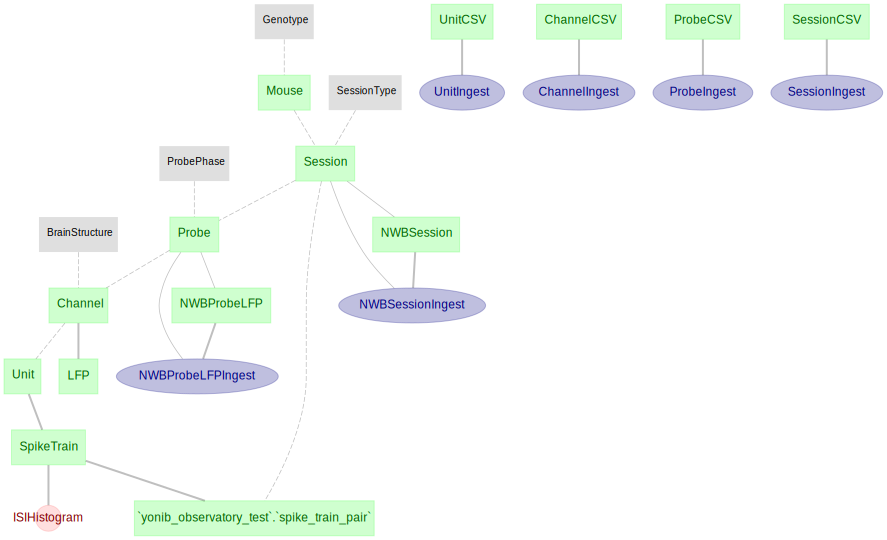

In [38]:
@schema 
class Genotype(dj.Lookup):
    definition = """
    genotype:varchar(255)
    """
    contents = zip(['Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
       'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
       'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'wt/wt'])

@schema
class SessionType(dj.Lookup):
    definition = """
    session_type:varchar(255)
    """
    contents = zip(['brain_observatory_1.1', 
                    'functional_connectivity'])


@schema
class Mouse(dj.Manual):
    definition = """
    # mouse information
    specimen_id: bigint  # unique mouse ID
    ---
    sex:enum('M','F','U') # Sex: Male, Female, Unkown
    -> Genotype
    dob:date
    """

# In my present formulation, things like channel and probe counts 
# and area ID can be found with queries but aren't included in the 
# Sessions table.
@schema
class Session(dj.Manual):
    definition = """
    session_id:bigint
    ---
    ->Mouse
    session_datetime:datetime
    ->SessionType
    publication_datetime:datetime
    has_nwb:bool
    isi_experiment_id:bigint
    """
@schema
class ProbePhase(dj.Lookup):
    definition = """
    probe_phase:varchar(255)
    """
    contents = zip(['3a', 'PXI'])

    
@schema 
class Probe(dj.Manual):
    definition = """
    probe_id:bigint
    ---
    ->Session
    ->ProbePhase
    probe_name:varchar(10)
    air_channel_index:int
    surface_channel_index:int
    sampling_rate:float
    lfp_sampling_rate:float

    """
@schema
class BrainStructure(dj.Lookup):
    definition = """
    brain_structure:varchar(10)
    """
    contents = zip(['APN', 'BMAa', 'CA1', 'CA2', 'CA3', 'COAa', 'COApm', 'CP', 'DG',
       'Eth', 'HPF', 'IGL', 'IntG', 'LD', 'LGd', 'LGv', 'LP', 'LT', 'MB',
       'MGd', 'MGm', 'MGv', 'MRN', 'NOT', 'OLF', 'OP', 'PF', 'PIL', 'PO',
       'POL', 'POST', 'PP', 'PPT', 'PRE', 'PoT', 'ProS', 'RPF', 'RT',
       'SCig', 'SCiw', 'SCop', 'SCsg', 'SCzo', 'SGN', 'SUB', 'TH', 'VIS',
       'VISal', 'VISam', 'VISl', 'VISli', 'VISmma', 'VISmmp', 'VISp',
       'VISpm', 'VISrl', 'VL', 'VPL', 'VPM', 'ZI', 'grey', 'nan'])
    
@schema
class Channel(dj.Manual):
    definition = """
    channel_id:bigint
    ---
    ->Probe
    ->BrainStructure
    structure_id = null:float
    local_channel_index:int
    probe_horizontal_position:int
    probe_vertical_position:int
    anterior_posterior_ccf_coordinate = null:float
    dorsal_ventral_ccf_coordinate = null:float
    left_right_ccf_coordinate=null:float
    """
    
@schema 
class Unit(dj.Manual):
    definition = """
    unit_id:bigint
    ---
    ->Channel
    pt_ratio = null:float
    amplitude = null:float
    amplitude_cutoff = null:float
    cumulative_drift = null:float
    d_prime = null:float
    duration = null:float
    firing_rate = null:float
    halfwidth = null:float
    isi_violations = null:float
    isolation_distance = null:float
    l_ratio = null:float
    max_drift = null:float
    nn_hit_rate = null:float
    nn_miss_rate = null:float
    presence_ratio = null:float
    recovery_slope = null:float
    repolarization_slope = null:float
    silhouette_score = null:float
    snr = null:float
    spread = null:float
    velocity_above = null:float
    velocity_below = null:float
    """
    
# I would prefer to have spiketrain data be part of the unit,
# But this is going to make more sense if we don't load all NWB files
@schema
class SpikeTrain(dj.Manual):
    definition = """
    ->Unit
    ---
    spike_ts:longblob
    """
    
@schema 
class LFP(dj.Manual):
    definition = """
    ->Channel
    ---
    lfp_ts:float
    lfp:longblob
    """
    
dj.ERD(schema)

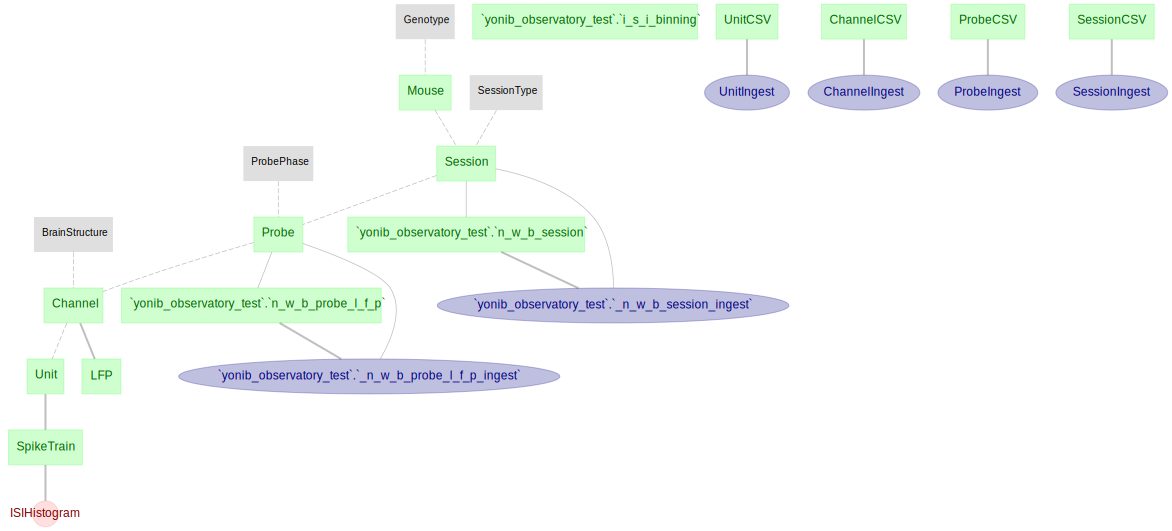

In [20]:
# This notation is borrowed from the mesoscale folks. 
# I am assuming that it is best practices?
#data_directory = 'C:\\Users\\yoni.browning\\Documents\\DataJoint\\AllenData'
#manifest_path = os.path.join(data_directory, "manifest.json")
#cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

@schema 
class SessionCSV(dj.Manual):
    definition = """
    session_csv:varchar(255)
    """
# Fix this later to get rid of For Loop   
@schema
class SessionIngest(dj.Imported):
    definition = """
    ->SessionCSV
    """
    
    def make(self,key):
        # For now, there is only one session file.
        self.insert1({'session_csv':
                      key['session_csv']},skip_duplicates = True)
        
        # 
        df=pd.read_csv(key['session_csv'],index_col = 'id')
        for session_id,row in df.iterrows():
            session_datetime = datetime.strptime(row['date_of_acquisition'], "%Y-%m-%dT%H:%M:%S%z")
            publication_datetime = datetime.strptime(row['published_at'], "%Y-%m-%dT%H:%M:%S%z")

            specimen_id = row['specimen_id']
            # Add the mouse data
            mouse_data = {'specimen_id':row['specimen_id'],
                         'sex':row['sex'],
                         'genotype':row['genotype'],
                         'dob':session_datetime.date()-timedelta(row['age_in_days'])}
            Mouse().insert1(mouse_data,skip_duplicates = True)
            # Add the Session data
            session_data = {'session_id':session_id,
                            'specimen_id':row['specimen_id'],
                            'session_datetime':session_datetime,
                            'publication_datetime':publication_datetime,
                            'session_type':row['session_type'],
                            'has_nwb':row['has_nwb'],
                            'isi_experiment_id':row['isi_experiment_id'],
            }
            Session().insert1(session_data,skip_duplicates = True)

            
@schema 
class ProbeCSV(dj.Manual):
    definition = """
    probe_csv:varchar(255)
    """
# Fix this later to get rid of For Loop   
@schema 
class ProbeIngest(dj.Imported):
    definition = """
    ->ProbeCSV
    """
    
    def make(self,key):
        self.insert1({'probe_csv':
              key['probe_csv']},skip_duplicates = True)
        
         # 
        df=pd.read_csv(key['probe_csv'],index_col = 'id')
        
        
        for probe_id,row in df.iterrows():
            # Add the probe
            probe_data = {'probe_id':probe_id,
                            'session_id':row['ecephys_session_id'],
                            'probe_phase':row['phase'],
                            'probe_name':row['name'],
                            'air_channel_index':row['air_channel_index'],
                            'surface_channel_index':row['surface_channel_index'],
                            'sampling_rate':row['sampling_rate'],
                            'lfp_sampling_rate':row['lfp_sampling_rate']}

            Probe().insert1(probe_data,skip_duplicates = True)
        

        
@schema 
class ChannelCSV(dj.Manual):
    definition = """
    channel_csv:varchar(255)
    """

# Note the difference in the insert commands between this Channel code and the code above. 
# Before, tables were small enough form repeat insert calls.
# Here, we needed to brake things down to a single call.
# This switches it from takeing "so long yoni stopped waiting " to ~20 seconds to run.
    
@schema 
class ChannelIngest(dj.Imported):
    definition = """
    ->ChannelCSV
    """
    
    def make(self,key):
        self.insert1({'channel_csv':
              key['channel_csv']},skip_duplicates = True)

        df=pd.read_csv(key['channel_csv'])
        df.rename(columns = {'id':'channel_id',
                         'local_index':'local_channel_index',
                         'ecephys_probe_id':'probe_id',
                         'ecephys_structure_acronym':'brain_structure',
                         'ecephys_structure_id':'structure_id'},inplace =True)
        df['brain_structure'] = df['brain_structure'].astype(str)
        df['structure_id'] = df['structure_id'].astype(float)
        df['anterior_posterior_ccf_coordinate'] = df['anterior_posterior_ccf_coordinate'].astype(float)
        df['dorsal_ventral_ccf_coordinate'] = df['dorsal_ventral_ccf_coordinate'].astype(float)
        df['left_right_ccf_coordinate'] = df['left_right_ccf_coordinate'].astype(float)


        df_dict = df.to_dict(orient = 'records')
        Channel().insert(tuple(df_dict),skip_duplicates = True)

        
@schema 
class UnitCSV(dj.Manual):
    definition = """
    unit_csv:varchar(255)
    """
    
@schema 
class UnitIngest(dj.Imported):
    definition = """
    ->UnitCSV
    """
    
    def make(self,key):
        self.insert1({'unit_csv':
              key['unit_csv']},skip_duplicates = True)
        df=pd.read_csv(key['unit_csv'])
        df.rename(columns = {'id':'unit_id',
                     'PT_ratio':'pt_ratio',
                     'L_ratio':'l_ratio',
                     'ecephys_channel_id':'channel_id'},inplace =True)

        df_dict = df[['unit_id',
          'channel_id',
          'pt_ratio',
          'amplitude',
          'amplitude_cutoff',
          'cumulative_drift',
          'd_prime',
          'duration',
          'firing_rate',
          'halfwidth',
          'isi_violations',
          'isolation_distance',
          'l_ratio',
          'max_drift',
          'nn_hit_rate',
          'nn_miss_rate',
          'presence_ratio',
          'recovery_slope',
          'repolarization_slope',
          'silhouette_score',
          'snr',
          'spread',
          'velocity_above',
          'velocity_below',]].to_dict(orient = 'records')
        # gets anything that wasn't checkpointed
        num_records = len(df_dict)
        steps = np.append(np.arange(0,num_records,10000),num_records)
        print(num_records)
        for ii,sss in enumerate(steps[0:-1]):
            Unit().insert(tuple(df_dict[sss:steps[ii+1]]),skip_duplicates = True)


            

# There is a super annoying bug whereby if you don't draw the table,
# then it won't work
# dj.ERD(schema) is effectivly the same as a "commit" call
dj.ERD(schema)

In [ ]:
%%timeit -n 1 -r 1
SessionCSV.insert1({'session_csv':
                    'C:\\Users\\yoni.browning\\Documents\\DataJoint\\AllenData\\sessions.csv'},skip_duplicates=True)
SessionIngest.populate()

In [ ]:
%%timeit -n 1 -r 1
ProbeCSV.insert1({'probe_csv':
                    'C:\\Users\\yoni.browning\\Documents\\DataJoint\\AllenData\\probes.csv'},skip_duplicates=True)
ProbeIngest.populate()
Probe()

In [ ]:
%%timeit -n 1 -r 1
ChannelCSV.insert1({'channel_csv':
                    'C:\\Users\\yoni.browning\\Documents\\DataJoint\\AllenData\\channels.csv'},skip_duplicates=True)
ChannelIngest.populate()
Channel()

In [ ]:
%%timeit -n 1 -r 1
UnitCSV.insert1({'unit_csv':
                    'C:\\Users\\yoni.browning\\Documents\\DataJoint\\AllenData\\units.csv'},skip_duplicates=True)
UnitIngest.populate()

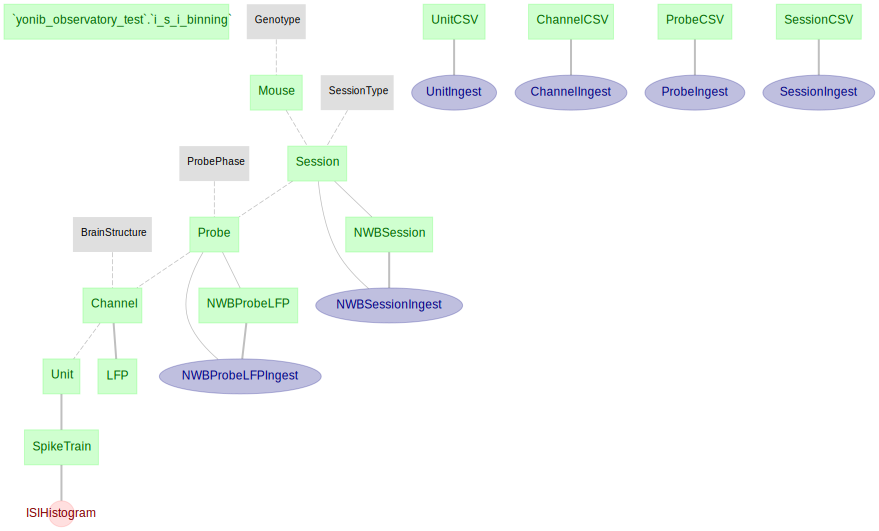

In [21]:
@schema
class NWBSession(dj.Manual):
    definition = """
    nwb_file:varchar(255)
    ->Session
    """
@schema
class NWBProbeLFP(dj.Manual):
    definition = """
    nwb_file:varchar(255)
    ->Probe
    """

# This code will only find units that match existing ones in the database
# Its a stop gap for now...
@schema 
class NWBSessionIngest(dj.Imported):
    definition = """
    ->NWBSession
    ->Session
    """
    
    def make(self,key):
        self.insert1(key)
        this_session_id = key['session_id']

        f = h5py.File(key['nwb_file'],'r')
        
        # Find the unit
        nwb_unit_ids = f['units']['id'][:]
        
        # Find the units from this session
        session_units = (Unit()& (Channel()&(Probe()&'session_id = ' + str(this_session_id)))).fetch(format = 'frame')
        
        # Find the overlapping set
        nwb_unit_idx = np.where(np.isin(nwb_unit_ids,session_units.index))[0]
        
        #
        spike_train = []
        spike_train_borders = np.append(f['units']['spike_times_index'],len(f['units']['spike_times']))
        for ii in range(0,len(spike_train_borders)-1):
            start = spike_train_borders[ii]
            stop = spike_train_borders[ii+1]
            this_spike_train = f['units']['spike_times'][start:stop]
            spike_train.append(this_spike_train)
        
        # This could likely be made faster, but I have split it up here just in case we are about to hit write time limits
        # This is something to play with once we have everything else working.
        for ii,this_nwb_unit_idx in enumerate(nwb_unit_idx):
            SpikeTrain().insert1({'unit_id':f['units']['id'][this_nwb_unit_idx],
                                 'spike_ts':spike_train[this_nwb_unit_idx]})
@schema 
class NWBProbeLFPIngest(dj.Imported):
    definition = """
    ->NWBProbeLFP
    ->Probe
    """
    def make(self,key):
        self.insert1(key)
        this_probe_id = key['probe_id']
        this_session_id = (Probe()&('probe_id = ' + str(key['probe_id']))).fetch1('session_id')
        session_filename ='session_' +str(this_session_id)
        s = h5py.File('C:/Users/yoni.browning/Documents/DataJoint/AllenData/'+session_filename + '/' +session_filename +'.nwb','r')
        
        probe_filename ='probe_' +str(this_probe_id)+'_lfp'
        p = h5py.File('C:/Users/yoni.browning/Documents/DataJoint/AllenData/'+session_filename + '/' +probe_filename +'.nwb','r')

        channel_id_list = s['general']['extracellular_ephys']['electrodes']['id'][:]
        local_index_list = s['general']['extracellular_ephys']['electrodes']['local_index'][:]
        probe_id_list = s['general']['extracellular_ephys']['electrodes']['probe_id'][:]

        


dj.ERD(schema)


In [ ]:

data_directory = 'C:/Users/yoni.browning/Documents/DataJoint/AllenData'
# This can be schematized better, but for what I am doing now it doesn't matter.
get_session_ids = [715093703,719161530,721123822]
# Get the sessions
nwb_session = NWBSession()
for ii in range(0,len(get_session_ids)):
    directory = os.path.join(data_directory + '/session_' + str(get_session_ids[ii]))
    files = os.listdir(directory)
    for jj,file in enumerate(files):
        print(file)
        if 'probe' in file:
            NWBProbeLFP().insert1({'nwb_file':os.path.join(directory,file),'probe_id':int(file.split('_')[1].split('.')[0])},skip_duplicates=True)
        else:
            NWBSession().insert1({'nwb_file':os.path.join(directory,file),'session_id':get_session_ids[ii]},skip_duplicates=True)

NWBSessionIngest.populate()
            

In [ ]:
NWBProbeLFPIngest().populate()


In [ ]:
s = h5py.File('C:/Users/yoni.browning/Documents/DataJoint/AllenData/session_715093703/session_715093703.nwb','r')
p = h5py.File('C:/Users/yoni.browning/Documents/DataJoint/AllenData/session_715093703/probe_810755805_lfp.nwb','r')
channel_id_list = s['general']['extracellular_ephys']['electrodes']['id'][:]
local_index_list = s['general']['extracellular_ephys']['electrodes']['local_index'][:]
probe_id_list = s['general']['extracellular_ephys']['electrodes']['probe_id'][:]
lfp_data = p['acquisition']['probe_810755805_lfp_data']['data']

In [ ]:
spike_train = []
spike_train_borders = np.append(f['units']['spike_times_index'],len(f['units']['spike_times']))
for ii in range(0,len(spike_train_borders)-1):
    start = spike_train_borders[ii]
    stop = spike_train_borders[ii+1]
    this_spike_train = f['units']['spike_times'][start:stop]
    spike_train.append(this_spike_train)

In [ ]:
NWBSession()&'nwb_file = "C:\\Users\\yoni.browning\\Documents\\DataJoint\\AllenData\\session_715093703\\session_715093703.nwb"'

In [ ]:
NWBSession().drop()

In [ ]:
A = (SpikeTrain()*(Unit() & (Channel() &(Probe()&(Session() &'session_id = 715093703'))))).fetch(format = 'frame')

In [ ]:
plt.hist(np.diff(A.spike_ts[1]),1000)


In [ ]:
b = np.diff(A.spike_ts[1])
[x,y] = np.histogram(b,.001*np.arange(0,500))
plt.plot(x)

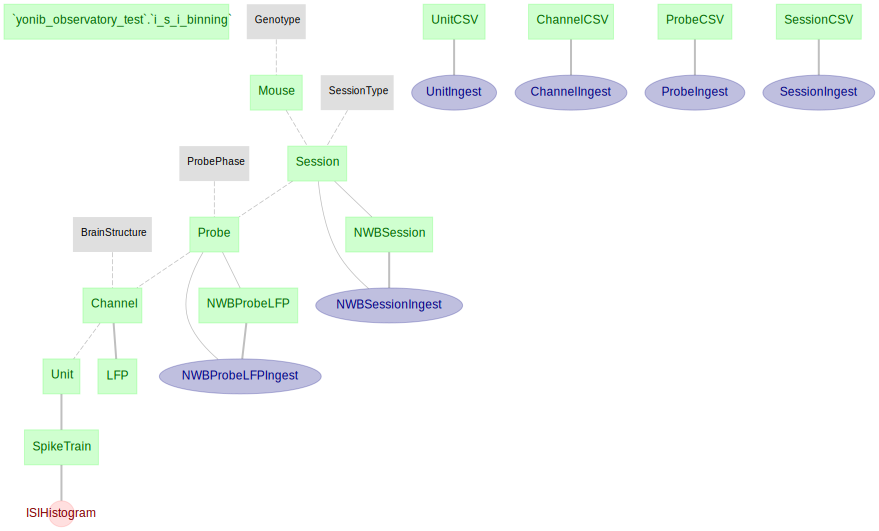

In [22]:
@schema
class ISIHistogram(dj.Computed):
    definition = """
    ->SpikeTrain
    ---
    isi_dist:longblob
    """
    
    def make(self,key):
        unit_data = (SpikeTrain()&key).fetch1()
        isi = np.diff(unit_data['spike_ts']) 
        [key['isi_dist'],_] = np.histogram(isi,.001*np.arange(0,500))
        self.insert1(key)
        print(key['unit_id'])

        

dj.ERD(schema)

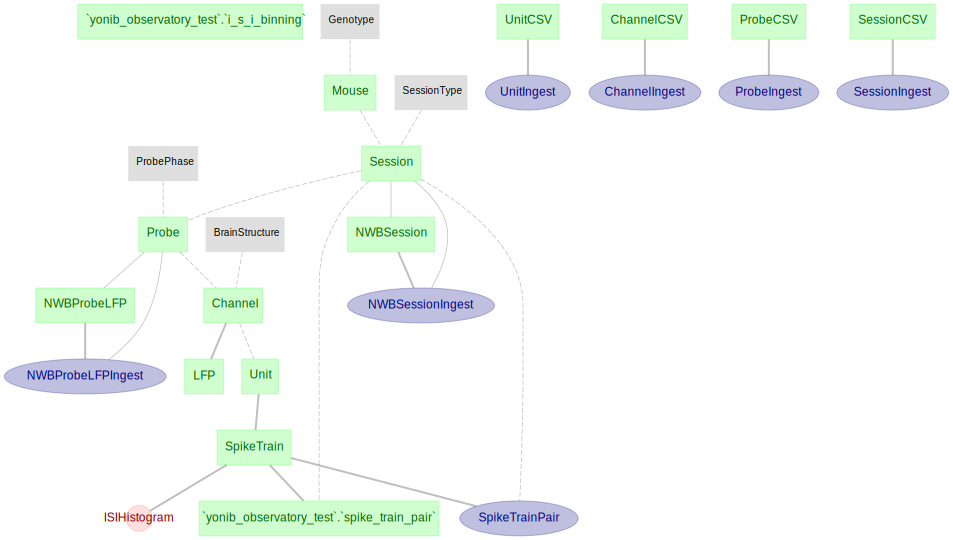

In [32]:
@schema
class SpikeTrainPair(dj.Imported):
    definition="""
    SpikeTrain1->SpikeTrain
    SpikeTrain2->SpikeTrain
    ---
    ->Session
    """
    def make(self,key):
        print(key.keys())

dj.ERD(schema)

In [8]:
ISI = ISIHistogram().fetch(format = 'frame')

In [35]:
@schema
class ISIBinning(dj.Manual):
    definition="""
        x:int
    """

In [36]:
ISIBinning.drop()

`yonib_observatory_test`.`i_s_i_binning` (0 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.
